In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train.csv
User uploaded file "train.csv" with length 68802655 bytes


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-04-23 03:13:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-23 03:13:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  6.55MB/s    in 92s     

2019-04-23 03:14:40 (8.90 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       y

replace 

In [0]:
!ls

adc.json	   glove.6B.200d.txt  glove.6B.50d.txt	glove.6B.zip.1
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	sample_data


In [0]:

path = ''

EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
# TEST_DATA_FILE=f'{path}test.csv'

In [0]:


# configuring basic parameters

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


In [0]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
# test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
# list_sentences_test = test["comment_text"].fillna("_na_").values



In [0]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))


In [0]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
# X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))




In [0]:
# Use these vectors to create our embedding matrix, with random initialization 
# for words that aren't in GloVe. We'll use the same mean and stdev of embeddings 
# the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)

x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)

x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)

x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [29]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_t, y, 
          batch_size=32, 
          epochs=5, 
          validation_split=0.3);



Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 4283s 38ms/step - loss: 0.0723 - acc: 0.9760 - val_loss: 0.0581 - val_acc: 0.9793
Epoch 2/5
111699/111699 [==============================] - 4280s 38ms/step - loss: 0.0508 - acc: 0.9816 - val_loss: 0.0506 - val_acc: 0.9818
Epoch 3/5
111699/111699 [==============================] - 4097s 37ms/step - loss: 0.0467 - acc: 0.9827 - val_loss: 0.0490 - val_acc: 0.9820
Epoch 4/5
111699/111699 [==============================] - 4073s 36ms/step - loss: 0.0441 - acc: 0.9833 - val_loss: 0.0488 - val_acc: 0.9822
Epoch 5/5
111699/111699 [==============================] - 4055s 36ms/step - loss: 0.0419 - acc: 0.9838 - val_loss: 0.0495 - val_acc: 0.9826


In [0]:
# And finally, get predictions for the test set and prepare a submission CSV:

# y_test = model.predict([X_te], batch_size=1024, verbose=1)
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')
# sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
__________

In [31]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

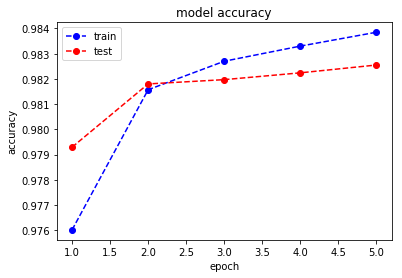

In [32]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

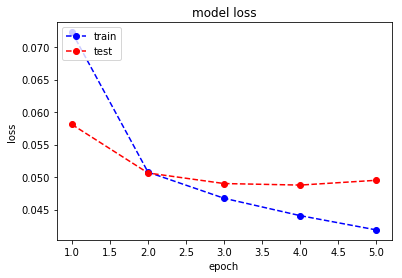

In [33]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
from keras.models import model_from_json
model_json = model.to_json()
with open("3BiLSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("3BiLSTM_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('3BiLSTM_model.json')
files.download('3BiLSTM_model.h5')

In [0]:
def sample_test(S1):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])

In [0]:
S1 = input("Sentence: ")
sample_test(S1)

In [0]:
S1 = input("Sentence: ")
sample_test(S1)


In [0]:
S1 = input("Sentence: ")
sample_test(S1)


In [0]:
S1 = input("Sentence: ")
sample_test(S1)


In [0]:
S1 = input("Sentence: ")
sample_test(S1)

In [0]:
S1 = input("Sentence: ")
sample_test(S1)